In [152]:
import nengo
import nengo.spa as spa
import numpy as np
import matplotlib.pyplot as plt
import random

from nengo_learn_assoc_mem.learn_assoc import LearningAssocMem
from nengo_learn_assoc_mem.utils import gen_feed_func

%matplotlib inline

In [153]:
t_present = 0.3
n_present = 6
dt = 0.001

n_items = 6
dimensions = 32
n_neurons = 20
intercept = 0.1

In [154]:
rng = np.random.RandomState(seed=9)
k_vocab = spa.Vocabulary(dimensions, rng=rng)

for i in range(n_items):
    k_vocab.parse('K%d' % i)

items = list(range(n_items)) * n_present
random.shuffle(items)
vocab_keys = ['K%d' % i for i in items]

In [155]:
print((np.dot(k_vocab.vectors, k_vocab.vectors.T) - np.eye(n_items)).flatten().max())
print("max simi: %s" % k_vocab.max_similarity)

0.0357712413694
max simi: 0.1


In [156]:
with nengo.Network() as train_model:
    stim = nengo.Node(gen_feed_func(k_vocab, vocab_keys, t_present))
    correct = nengo.Node(gen_feed_func(k_vocab, vocab_keys, t_present))

    mem = LearningAssocMem(n_neurons=n_neurons, dimensions=dimensions, intercepts=[intercept] * n_neurons)
    
    nengo.Connection(stim, mem.input, synapse=None)
    nengo.Connection(correct, mem.correct, synapse=None)
    
    p_out = nengo.Probe(mem.output, synapse=0.01)
    p_ideal = nengo.Probe(correct, synapse=None)
    
    p_dec = nengo.Probe(mem.conn_out, 'weights', sample_every=t_present/2)
    p_enc = nengo.Probe(mem.mem, 'scaled_encoders', sample_every=t_present/2)

In [157]:
with nengo.Simulator(train_model) as train_sim:
    train_sim.run(n_present*n_items*t_present)

enc = train_sim.data[p_enc][-1]
dec = train_sim.data[p_dec][-1]

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:04.                                                 


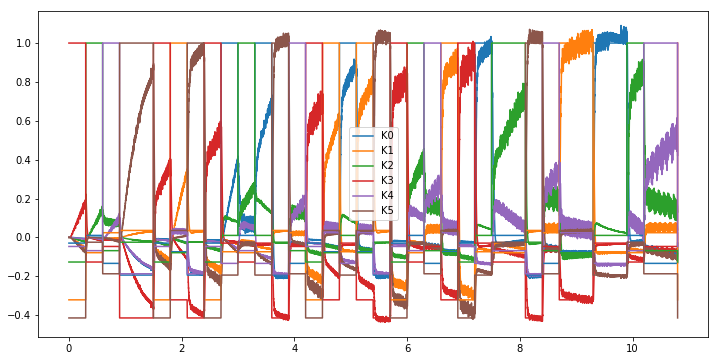

In [158]:
plt.figure(figsize=(12, 6))

plt.plot(train_sim.trange(), spa.similarity(train_sim.data[p_out], k_vocab))

plt.gca().set_prop_cycle(None)

plt.plot(train_sim.trange(), spa.similarity(train_sim.data[p_ideal], k_vocab))

plt.legend(k_vocab.keys)

In [159]:
with nengo.Network() as test_model:
    stim = nengo.Node(gen_feed_func(k_vocab, k_vocab.keys, t_present))
    correct = nengo.Node(gen_feed_func(k_vocab, k_vocab.keys, t_present))

    recall = nengo.Node(size_in=dimensions)

    test_mem = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions,
                              encoders=enc,
                              intercepts=[intercept] * n_neurons)
    
    nengo.Connection(stim, test_mem, synapse=None)
    nengo.Connection(test_mem.neurons, recall, transform=dec)
    
    p_rec = nengo.Probe(recall, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)

In [160]:
with nengo.Simulator(test_model) as test_sim:
    test_sim.run(n_items*t_present)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


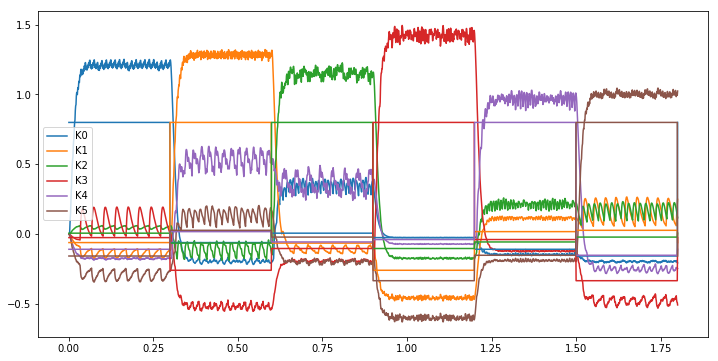

In [161]:
plt.figure(figsize=(12, 6))

plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_rec], k_vocab))

plt.gca().set_prop_cycle(None)

plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_cor], k_vocab)*0.8)

plt.legend(k_vocab.keys)